In [7]:
## general
import sys, glob
import numpy as np
import xarray as xr
import datetime as dt
import pandas as pd

## statistics
from scipy import stats 
from scipy.optimize import curve_fit, fmin, fminbound, minimize, rosen_der

## plotting
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry.polygon import Polygon

import warnings
warnings.filterwarnings("ignore") 

In [2]:
import conditional_distributions

In [3]:
path_to_data = '../reversal_of_the_impact_chain/data/Berlin_daily_mean_tas_JJA'

In [4]:
all_files = sorted(glob.glob(path_to_data + '/*'))
all_esms = [fl.split('/')[-1].split('.')[0] for fl in all_files]

In [5]:
dstr = conditional_distributions.normal()
pN012 = pd.DataFrame(index=all_esms, columns=dstr._param_names)
pN0123 = pd.DataFrame(index=all_esms, columns=dstr._param_names)
dstr = conditional_distributions.skewN()
psN0234 = pd.DataFrame(index=all_esms, columns=dstr._param_names)
psN02345 = pd.DataFrame(index=all_esms, columns=dstr._param_names)
psN012345 = pd.DataFrame(index=all_esms, columns=dstr._param_names)

for esm,fl in zip(all_esms,all_files):
    print(esm, fl)
    data = xr.open_dataset(fl)
    tas,gmt = data['tas'], data['gmt']
    N = conditional_distributions.normal()
    N.add_data(gmt=gmt, x=tas)
    pN012.loc[esm] = N.try_different_methods_until_success(p=[17,1,1,0], fitting_steps=[[0,1,2]])
    pN0123.loc[esm] = N.try_different_methods_until_success(p=list(pN012.loc[esm]), fitting_steps=[[0,1,2],[0,1,2,3]], bound_frac=0.2)
    
    sN = conditional_distributions.skewN()
    sN.add_data(gmt=gmt, x=tas)
    psN0234.loc[esm] = sN.try_different_methods_until_success(p=[1,0,17,1,1,0], fitting_steps=[[0,2,3,4]], bound_frac=0.1)
    psN02345.loc[esm] = sN.try_different_methods_until_success(p=list(psN0234.loc[esm]), fitting_steps=[[0,2,3,4],[5]], bound_frac=0.1)
    psN012345.loc[esm] = sN.try_different_methods_until_success(p=list(psN02345.loc[esm]), fitting_steps=[[0,2,3,4],[5],[1]], bound_frac=0.1)

ACCESS-CM2 ../reversal_of_the_impact_chain//data/Berlin_daily_mean_tas_JJA/ACCESS-CM2.nc
BCC-CSM2-MR ../reversal_of_the_impact_chain//data/Berlin_daily_mean_tas_JJA/BCC-CSM2-MR.nc
CESM2-WACCM ../reversal_of_the_impact_chain//data/Berlin_daily_mean_tas_JJA/CESM2-WACCM.nc
CESM2 ../reversal_of_the_impact_chain//data/Berlin_daily_mean_tas_JJA/CESM2.nc
CNRM-CM6-1 ../reversal_of_the_impact_chain//data/Berlin_daily_mean_tas_JJA/CNRM-CM6-1.nc
CNRM-ESM2-1 ../reversal_of_the_impact_chain//data/Berlin_daily_mean_tas_JJA/CNRM-ESM2-1.nc
EC-Earth3-Veg-LR ../reversal_of_the_impact_chain//data/Berlin_daily_mean_tas_JJA/EC-Earth3-Veg-LR.nc
EC-Earth3-Veg ../reversal_of_the_impact_chain//data/Berlin_daily_mean_tas_JJA/EC-Earth3-Veg.nc
EC-Earth3 ../reversal_of_the_impact_chain//data/Berlin_daily_mean_tas_JJA/EC-Earth3.nc
GFDL-ESM4 ../reversal_of_the_impact_chain//data/Berlin_daily_mean_tas_JJA/GFDL-ESM4.nc
HadGEM3-GC31-LL ../reversal_of_the_impact_chain//data/Berlin_daily_mean_tas_JJA/HadGEM3-GC31-LL.nc
H

In [14]:
for params, name in zip([pN012, pN0123, psN0234, psN02345, psN012345], ['pN012', 'pN0123', 'psN0234', 'psN02345', 'psN012345']):
    params.to_csv(path_to_data + '/%s.csv' %(name))

In [8]:
# https://github.com/tanderson11/curlybrace
sys.path.append('/home/peter/Projects/git-packages/curlybrace/curlybrace/')
from curlyBrace import curlyBrace

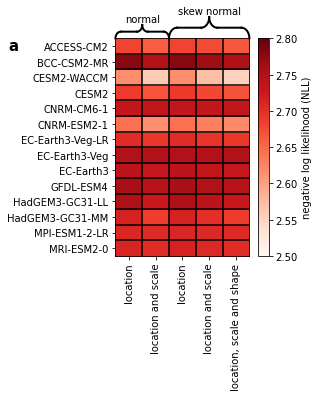

In [10]:
def plot_skill_tabel(skill_metric_function, cbarlabel, vmin, vmax):
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = matplotlib.cm.Reds
    fig, ax = plt.subplots(nrows=1, figsize=(3,4))
    r = 0
    for r,esm,fl in zip(range(len(all_esms)),all_esms,all_files):
        data = xr.open_dataset(fl)
        tas,gmt = data['tas'], data['gmt']
        N = conditional_distributions.normal()
        N.add_data(gmt=gmt, x=tas)
        sN = conditional_distributions.skewN()
        sN.add_data(gmt=gmt, x=tas)
        for c,params,dstr,k in zip(range(5), [pN012, pN0123, psN0234, psN02345, psN012345], [N,N,sN,sN,sN], [3,4,4,5,6]):
            stat = skill_metric_function(dstr, params.loc[esm], k)
            ax.fill_between([c-0.5,c+0.5], [r-0.5]*2, [r+0.5]*2, color=cmap(norm(stat)))
    ax.set_yticks(range(14)[::-1])
    ax.set_yticklabels(pN012.index.values)
    ax.set_xticks(range(5))
    _ = ax.set_xticklabels([
        'location',    
        'location and scale',
        'location',
        'location and scale',
        'location, scale and shape',
    ], rotation=90, va='top')
    curlyBrace(fig, ax, (-0.5,r+0.5), (1.5,r+0.5), 0.1, bool_auto=True, str_text="normal", color='k', lw=2, int_line_num=1, clip_on=False)
    curlyBrace(fig, ax, (1.5,r+0.5), (4.5,r+0.5), 0.1, bool_auto=True, str_text="skew normal", color='k', lw=2, int_line_num=1, clip_on=False)

    for x in range(4):
        ax.axvline(x=x+0.5, color='k')
    ax.set_xlim(-0.5,4.5)
    for y in range(13):
        ax.axhline(y=y+0.5, color='k')
    ax.set_ylim(-0.5,13.5)
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
                 ax=ax, orientation='vertical', label=cbarlabel)
    plt.annotate('a', xy=(-0.8,1), ha='left', va='top', xycoords='axes fraction', fontsize=15, fontweight='bold')
    
    
def NLL(dstr, params, k):
    return dstr.neg_loglike(params)

plot_skill_tabel(NLL, 'negative log likelihood (NLL)', vmin=2.5, vmax=2.8)

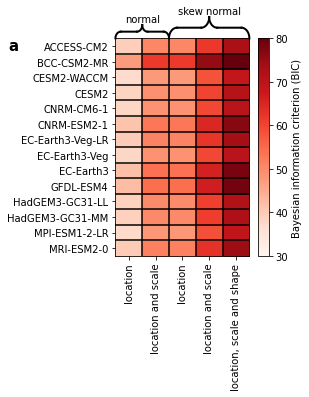

In [11]:
def BIC(dstr, params, k):
    return dstr.BIC(params, k)

plot_skill_tabel(BIC, 'Bayesian information criterion (BIC)', vmin=30, vmax=80)

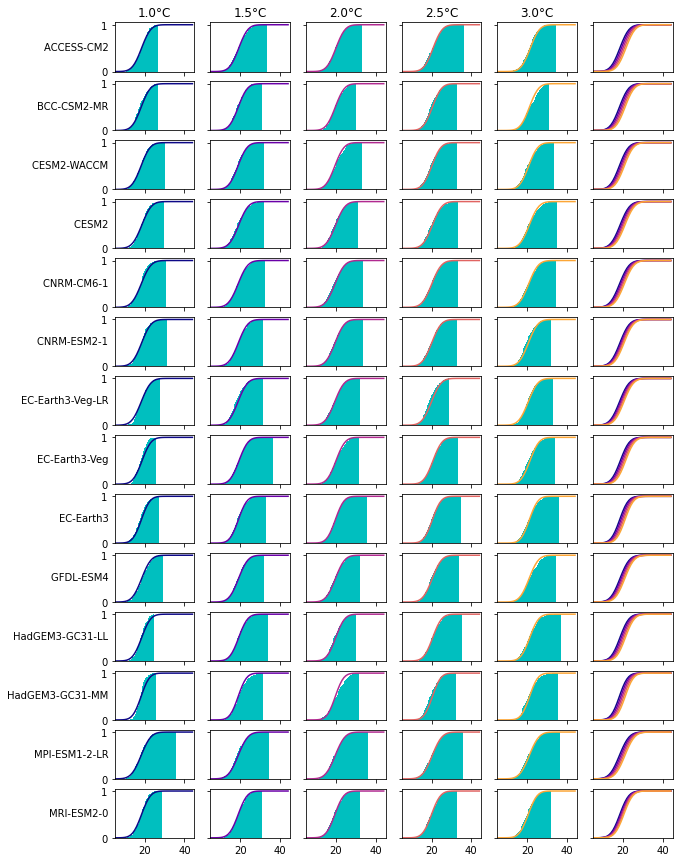

In [12]:
fig,axes = plt.subplots(nrows=14, ncols=6, figsize=(10,15), sharey=True, sharex=True)
for ax in axes.flatten():
    ax.set_facecolor('w')
x_axis = np.arange(5,45,1)
for r,esm,fl in zip(range(len(all_esms)),all_esms,all_files):
    data = xr.open_dataset(fl)
    tas,gmt = data['tas'], data['gmt']
    N = conditional_distributions.normal()
    N.add_data(gmt=gmt, x=tas)
    for c,gmt in enumerate(np.arange(1,3.5,0.5).round(1)):
        color = matplotlib.cm.get_cmap('plasma')(c/5)
        axes[r,c].hist(N.gmt_slice(gmt)[1], density=True, cumulative=True, bins=50, color='c')
        axes[r,c].plot(x_axis, N.cdf(gmt, x_axis, pN012.loc[esm]), color=color)
        axes[r,5].plot(x_axis, N.cdf(gmt, x_axis, pN012.loc[esm]), color=color)
        axes[r,c].set_xlim(5,45)
        if r == 0:
            axes[r,c].set_title(str(gmt)+'°C')
    axes[r,0].annotate(esm+'  ', xy=(0,0.5), xycoords='axes fraction', ha='right', va='center')